# Mapping human Paed thymus Visium sections with paed reference

## Contents
* [Loading packages](#Loading_packages)
* [Loading Visium and single cell data data](#Loading_Visium)
1. [Estimating cell type signatures (NB regression)](#Estimating_signatures)
2. [Cell2location: spatial mapping](#cell2location)
3. [Visualising cell abundance in spatial coordinates](#Visualising)
4. [Downstream analysis](#downstream)
* [Leiden clustering of cell abundance](#region_clustering)
* [Identifying cellular compartments / tissue zones using matrix factorisation (NMF)](#NMF)
5. [Advanced use](#advanced)
* [Estimate cell-type specific expression of every gene in the spatial data](#per_cell_type_expression)
* [Working with the posterior distribution and computing arbitrary quantiles](#posterior_summary)

In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

## Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100
from datetime import date
today = str(date.today())
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'pdf')

sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2
import os
os.getcwd()

Global seed set to 0
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Running Scanpy 1.9.1, on 2023-08-10 23:23.


'/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure6'

First, let's define where we save the results of our analysis:

In [2]:
results_folder = '/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_hyper2_paed_CITE_v11_v2'
if not os.path.exists(results_folder):
    os.mkdir(results_folder)
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'
if not os.path.exists(ref_run_name):
    os.mkdir(ref_run_name)
if not os.path.exists(run_name):
    os.mkdir(run_name)

# Step 0 - objects cleanup

## Cleanup gex 

In [3]:
gex = sc.read("/nfs/team205/ny1/ThymusSpatialAtlas/Figure1/annotation_done/Thymus_Atlas_v8.h5ad") # load most recent atlas object 

In [4]:
gex = gex[gex.obs['cell_type_level_0']!='FailQC'] # remove bad cells
anno = 'anno_CITE_4v6'
gex


View of AnnData object with n_obs × n_vars = 498018 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_cou

In [5]:
# update other cells from non T cells 
gex.obs[anno] = gex.obs.apply(lambda x: np.nan if x['age_group'] == 'fetal' else
                                                            x['cell_type_level_4'] if x['anno_CITE_4v5'] == 'B' else 
                                                            x['cell_type_level_4'] if x['anno_CITE_4v5'] == 'DC' else 
                                                            x['anno_CITE_4v5'] if x['study'] == 'SpatialAtlas-Taghon' else
                                                            x['cell_type_level_4'] if x['cell_type_level_0'] != 'T' else
                                         np.nan, axis = 1)

gex = gex[~gex.obs[anno].isna()]
gex = gex[gex.obs[anno] != 'nan']
gex.obs[anno] = gex.obs[anno].astype('category')

prolif_cells = ['DC1-Prolif', 'DC2-Prolif', 'pDC-Prolif', 'PeriloFb-Prolif', 'ProlifPericyte','mcTEC-Prolif',
               'B-Prolif']
fet_specific = ['pro_B', 'late_pro_B', 'large_pre_B', 'small_pre_B', 'CMP', 'GMP', 'InterloFb-COL9A3',
                'fetFB-NKX2-5', 'fetFB-CCL21','fetFB-RSPO2', 'Mesothelium', 'mcTEC-Prolif',
               'T_NK_fetal', ]
unclear = ['T_DP(Q)-HSPH1','T_SP8or4','T_SP-HSP','T_DN(Q)-stress_1','T_DN(Q)-stress_2','T_DN(Q)-intermediate','T_Treg-intermediate']
to_remove = set(gex.obs[anno].value_counts().loc[gex.obs[anno].
                                                                      value_counts()<=40].index.tolist()+
            prolif_cells + fet_specific + unclear)

gex = gex[~gex.obs[anno].isin(to_remove),:].copy()
# take cells from each sample 
def subset_by_anno(adata, cluster_key , target_cells=20000):
    adatas = [adata[adata.obs[cluster_key] == clust].copy() for clust in adata.obs[cluster_key].cat.categories]
    for dat in adatas:
        if dat.n_obs > target_cells:
            sc.pp.subsample(dat, n_obs=target_cells)
    adata_sub = adatas[0].concatenate(*adatas[1:])
    return adata_sub

gex = subset_by_anno(gex, anno,target_cells=10000)

/tmp/ipykernel_25776/2788159333.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gex.obs[anno] = gex.obs.apply(lambda x: np.nan if x['age_group'] == 'fetal' else
/tmp/ipykernel_25776/2788159333.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gex.obs[anno] = gex.obs[anno].astype('category')
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [8]:
# see cell proportions
anno = 'anno_CITE_4v6'
for i, j in gex.obs[anno].value_counts().items():
    print(str(i) + ' ' + str(j))

DP_4hi8lo 10000
DP(Q)_rearr 10000
DP(P)_early 10000
committed_CD4pos 6497
DP_pos_sel 6153
SP_CD4_semimature 5499
DP(Q)_CD199 5337
SP_CD4_immature 4681
DP(Q)_early 4672
SP_CD8_semimature 4495
DP(Q)_CD99_CD31lo 4115
committed_CD4neg 3843
DP_early_CD31 3020
DP(Q)_CD99_CD31hi 2927
mTECI 2880
mcTEC 2764
cTECIII 2153
SP_Treg_mature 2119
SP_CD8_immature 2030
cTECI 1967
SP_Treg_immature 1658
cTECII 1589
SMC 1567
EC-Ven 1539
B-memory 1366
PeriloFb 1320
TEC-neuro 1235
InterloFb 1231
B-naive 1002
DP(Q)_HSPH1 979
EC-Cap 865
CD8aaI_immature 827
mTECII 789
mTECIII 742
EC-Art 720
SP_CD4_mature 714
CD8aaII_mature 712
CD8aaII_immature 646
SP_Treg_PD1 575
medFb-RGS5 552
TEC-myo 500
CD8aaI_mature 487
TEC-cilliated 474
DP(P)_late 378
SP_CD8_mature 371
medFB-MHCIIh 362
gdT_semimature 354
SP_Treg_CD8 353
committed_CD4neg(P) 335
Pericyte 334
mTECI-trans 325
pDC 294
DC1 269
aDC3 264
NK_tr_itg_hi 192
gdT_immature 189
medFb 180
Pericyte_CCL19 171
SP_Treg_recirc 168
uncommitted 163
NKT_dev 149
committed_CD4pos(P

In [9]:
sc.pl.umap(gex, color = ['cell_type_level_2', 'anno_CITE_4v6'], legend_loc = "on data", 
          legend_fontsize = 7, frameon = False)

In [10]:
gex

AnnData object with n_obs × n_vars = 123873 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_r

## Loading scRNA-seq reference data <a class="anchor" id="Loading_Visium"></a>

In [13]:
gex.obs['study'].value_counts()

SpatialAtlas-Taghon       96338
SpatialAtlas-Teichmann    12795
Bautista2021               7140
Campinoti2020              3917
Park2020                   3683
Name: study, dtype: int64

In [14]:
sc.pp.neighbors(gex,use_rep='X_scVI')
sc.tl.leiden(gex,resolution=35,key_added='hyper_leiden')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [15]:
anno = 'hyper_leiden'
list[gex.obs[anno].value_counts().keys()]

list[CategoricalIndex(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  ...
                  '615', '616', '617', '618', '619', '620', '621', '622',
                  '623', '624'],
                 categories=['0', '1', '2', '3', '4', '5', '6', '7', ...], ordered=False, dtype='category', length=625)]

In [16]:
# remove cells for paed that are fetal specific 
gex.obs[anno].value_counts()

0      720
1      610
2      574
3      573
4      568
      ... 
620     26
621     20
622     19
623     18
624      8
Name: hyper_leiden, Length: 625, dtype: int64

In [17]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_co_occurrence(adata, col1, col2):
    """
    Plot the co-occurrence of categories in an AnnData object.

    Parameters:
    adata: The AnnData object.
    col1: The name of the first column.
    col2: The name of the second column.
    """
    # Convert your AnnData observations (obs) to a DataFrame
    df = pd.DataFrame(adata.obs)

    # Use pandas crosstab to compute a simple cross tabulation of two (or more) factors. 
    # This will give us the number of times each combination of factors occurs.
    co_occurrence = pd.crosstab(df[col1], df[col2])

    # You can then use seaborn's heatmap function to visualize this
    plt.figure(figsize=(30, 30))
    sns.heatmap(np.log1p(co_occurrence), annot=False, cmap="Reds")

    plt.title(f'Co-occurrence of {col1} in {col2}')
    plt.show()


In [18]:
plot_co_occurrence(gex,col1='anno_CITE_4v6',col2='hyper_leiden')

## Highly variable gene selection

In [19]:
gex = gex.copy()
import scvi
# remove cell cycle genes and MT genes (optinal) 
cc_genes =  ['C1orf112', 'KDM1A', 'ARHGAP33', 'CDC27', 'AC004381.6', 'DBF4', 'PRSS21', 'E2F2', 'BAZ1B', 'NCAPD2', 'ANLN', 'BRCA1', 'UBR7', 'DDX11', 'TACC3', 'POLA2', 'DEPDC1', 'NCAPH2', 'HMGB3', 'CENPQ', 'DEPDC1B', 'SPDL1', 'TDP1', 'DSG2', 'NOP16', 'RFC2', 'RAD51', 'POLQ', 'THOC3', 'MRTO4', 'C4orf27', 'POLD1', 'TM7SF3', 'MCM10', 'MTHFD2', 'YBX1', 'ASPM', 'PRR11', 'NUCKS1', 'EXOC5', 'TCOF1', 'RAD18', 'TRIP13', 'DAZAP1', 'HLTF', 'PDCD2', 'SMC1A', 'HMMR', 'MCM2', 'NUP37', 'GTSE1', 'WDR62', 'MCM6', 'MLH1', 'UNG', 'SPAG5', 'UBE2T', 'EXOSC5', 'FAM76B', 'POLD3', 'KIF22', 'PUM3', 'RBL1', 'NDC80', 'HSPB11', 'OXCT1', 'SEH1L', 'ORC1', 'RAD54L', 'NOP14', 'GMCL1', 'AURKA', 'TPX2', 'BIRC5', 'KIF4A', 'FH', 'ORC6', 'G2E3', 'WDR76', 'PHGDH', 'CLSPN', 'NUP50', 'CDC45', 'CDC6', 'CBX5', 'MSH2', 'FKBP5', 'ACOT7', 'CDC7', 'RANBP1', 'CENPM', 'HMGXB4', 'MCM5', 'RANGAP1', 'POLE2', 'CDKN3', 'ERH', 'MTHFD1', 'VRK1', 'EMC9', 'GINS1', 'MYBL2', 'CDC25B', 'PLCB4', 'FAM83D', 'CEP76', 'RBBP8', 'POLA1', 'NUP93', 'CTCF', 'CCP110', 'CEP152', 'OIP5', 'MYEF2', 'MCM4', 'KCTD9', 'RNASEH2A', 'SGTA', 'ASF1B', 'LIG1', 'H2AFV', 'GARS', 'NUDT1', 'RPA3', 'EZH2', 'RHEB', 'SMC3', 'UBE2S', 'RAD51C', 'GALK1', 'C1QBP', 'BLMH', 'TMEM97', 'GAR1', 'NEIL3', 'WHSC1', 'NCAPG', 'CCDC34', 'CCDC86', 'MAGOHB', 'FOXM1', 'GPN3', 'RAD51AP1', 'RFC5', 'NUP107', 'TIMELESS', 'GAPDH', 'CDCA3', 'ENO2', 'FBXO5', 'MCM3', 'BAG2', 'GMNN', 'TTK', 'HMGCS1', 'BRD8', 'KIF20A', 'LMNB1', 'NUP155', 'H2AFY', 'SMC4', 'ECT2', 'CENPA', 'FHL2', 'MSH6', 'DHCR24', 'LRRC42', 'WDR77', 'SRM', 'MAD2L2', 'UCHL5', 'TTF2', 'SLC2A1', 'EBNA1BP2', 'CDC20', 'STMN1', 'NEK2', 'CENPF', 'KIF14', 'CASP8AP2', 'CTNNAL1', 'WDR34', 'PHF19', 'ACYP1', 'HELLS', 'CENPL', 'ACAT2', 'MASTL', 'EXOSC8', 'TMPO', 'NFYB', 'NCAPH', 'MND1', 'KIF18A', 'GPSM2', 'GTF3A', 'MRPS2', 'CCDC18', 'CISD1', 'ZWINT', 'CIT', 'DDX39A', 'CENPK', 'CDK2', 'TUBA1B', 'STIL', 'HJURP', 'EXOSC9', 'CKS2', 'ACSL3', 'CSE1L', 'HIST1H1D', 'HIST1H1A', 'DEK', 'GOT2', 'MGME1', 'MCM8', 'HNRNPR', 'BCL2L12', 'TRAP1', 'DLGAP5', 'YEATS4', 'PKMYT1', 'SRD5A3', 'PAICS', 'HAT1', 'KNSTRN', 'DUT', 'E2F8', 'FAM64A', 'MIS18BP1', 'SGOL1', 'RPS4Y1', 'LDLR', 'TOMM40', 'ATP8B3', 'LSM4', 'DNMT1', 'GINS2', 'TUBG1', 'PSMC3IP', 'THOC6', 'TOP2A', 'ENOSF1', 'RAN', 'RPA1', 'PCNA', 'NASP', 'RFC3', 'SLF1', 'LRRCC1', 'CCNB1', 'PSRC1', 'TMEM106C', 'LDHA', 'DDB2', 'CDCA8', 'TPGS2', 'SLC43A3', 'C9orf40', 'TROAP', 'ESPL1', 'NTPCR', 'CKAP2', 'BORA', 'NUDT15', 'BRIP1', 'ACTL6A', 'TXN', 'ODF2', 'SMC2', 'CDK5RAP2', 'ANP32B', 'DSCC1', 'ARHGEF39', 'PPIL1', 'TCF19', 'NRM', 'GGH', 'BUD13', 'CTDSPL2', 'NUSAP1', 'KIF23', 'CASC5', 'CENPO', 'KIF11', 'CEP55', 'KIF20B', 'DNA2', 'BARD1', 'MNS1', 'ZGRF1', 'CENPE', 'HADH', 'SLC39A8', 'NEDD1', 'BRCA2', 'DIAPH3', 'PIF1', 'FANCI', 'TICRR', 'SAMD1', 'SAE1', 'PLK4', 'ITGB3BP', 'KIF2C', 'UCK2', 'NUF2', 'ANP32E', 'DTL', 'ILF2', 'C1orf35', 'HNRNPLL', 'CHAC2', 'POLR2D', 'CDCA7', 'FANCD2', 'CCNA2', 'SKP2', 'PRIM2', 'MMS22L', 'PM20D2', 'MTFR2', 'CDCA5', 'NCAPG2', 'PRPS1', 'GINS4', 'HAUS6', 'CEP78', 'GTF3C5', 'MKI67', 'IMMP1L', 'SSRP1', 'INCENP', 'CCDC15', 'CHEK1', 'DSN1', 'HIRIP3', 'HMGA2', 'TEX30', 'NCAPD3', 'CENPU', 'CENPJ', 'SPC25', 'SUV39H2', 'CENPH', 'CARHSP1', 'CLGN', 'CCSAP', 'BUB3', 'SLFN13', 'SKA1', 'SLC16A1', 'TMEM237', 'ADK', 'FAM122B', 'AIFM1', 'ATAD2', 'SASS6', 'BUB1B', 'CCNB2', 'PSMG3', 'FAIM', 'CDC25C', 'MIS18A', 'ATP5G1', 'IGF2BP1', 'CHAF1B', 'NAE1', 'CCDC58', 'C21orf58', 'ZNF714', 'GPATCH4', 'YDJC', 'RACGAP1', 'SPC24', 'POLR3K', 'CCNF', 'ASRGL1', 'USP1', 'KIAA1524', 'SGOL2', 'TOPBP1', 'KIF15', 'WDR43', 'RFC4', 'RPL39L', 'RNF168', 'H2AFZ', 'CDC25A', 'POC1A', 'HMGB2', 'MAD2L1', 'PTTG1', 'RAD21', 'PSIP1', 'GKAP1', 'MELK', 'SLC7A3', 'SKA3', 'LRR1', 'HPRT1', 'E2F7', 'JAM3', 'BRD7', 'CENPN', 'LEO1', 'WEE1', 'MCM7', 'CENPV', 'SAAL1', 'FAM111A', 'KIAA0101', 'PLK1', 'XRCC6BP1', 'SNRPD1', 'RRM1', 'CDT1', 'CHAF1A', 'C19orf48', 'NUDT8', 'PRDX2', 'TK1', 'SAC3D1', 'PBK', 'HIST1H1E', 'DTYMK', 'RFWD3', 'FEN1', 'ING2', 'CDKN2AIP', 'SNRNP48', 'USP39', 'CKAP2L', 'BUB1', 'ELP5', 'CDK1', 'CDCA4', 'SHCBP1', 'PGAM1', 'ESCO2', 'RHNO1', 'CTPS1', 'RRM2', 'THOP1', 'C5orf34', 'POP7', 'ZNF738', 'CKS1B', 'GMPPB', 'CNP', 'CBX2', 'C16orf91', 'EXO1', 'ZWILCH', 'ANKRD36C', 'UBE2C', 'CKAP5', 'CCNE2', 'CCDC14', 'RMI2', 'TOMM5', 'RUVBL1', 'ATAD5', 'LMNB2', 'TYMS', 'PXMP2', 'SHMT1', 'POLE', 'PAWR', 'PIDD1', 'GSG2', 'GEN1', 'RMI1', 'AURKB', 'RCC1', 'PPA1', 'HIST3H2A', 'MRPS23', 'RTKN2', 'IDH2', 'KPNA2', 'CEP97', 'GLRX5', 'SKA2', 'CEP57L1', 'PSMG1', 'SFXN4', 'ALYREF', 'TRAIP', 'LIN9', 'KMT5A', 'PGP', 'CMSS1', 'HIST2H2AC', 'HIST1H1B', 'KNTC1', 'CDCA2', 'H1FX', 'SIVA1', 'PARPBP', 'KIF18B', 'ERCC6L', 'PTMA', 'HSPA14', 'FANCA', 'ARHGAP11B', 'TUBB4B', 'CENPP', 'H2AFX', 'FAM72B', 'FAM221A', 'FAM111B', 'HN1', 'HMGB1', 'TUBB', 'IARS', 'ERI2', 'HIST1H4C', 'BLM', 'PRIM1', 'HMGN5', 'SVIP', 'TFDP1', 'TXNRD1', 'WDHD1', 'EIF1AY', 'ARHGAP11A', 'HMGN2', 'DCAF12', 'PRC1', 'CCDC167', 'CENPW', 'GPANK1', 'MZT1', 'C4orf46', 'KLHL23', 'MXD3', 'DNAJC9', 'IFRD2', 'CKLF', 'FANCG', 'DHFR', 'DLEU2', 'AP000251.3', 'KIFC1', 'CRNDE', 'C8orf88', 'PRKDC', 'BOP1', 'RP11-196G18.23', 'CTC-260E6.6', 'NCBP2-AS2', 'HIST1H3G', 'HIST1H2AH', 'UHRF1', 'RDM1', 'HIST1H2AM']
gex = gex[:,~gex.var['cite']] # remove cite genes

def remove_selected_genes(adata,lst,remove_also_mt=True):
    for g in lst:
        adata = adata[:,~(adata.var_names==g)]
    if remove_also_mt:
        adata = adata[:,~(adata.var_names.str.startswith('MT-'))]
    return adata

gex = remove_selected_genes(gex,cc_genes,remove_also_mt=True)  

In [20]:
sc.pp.highly_variable_genes(
        gex,
        n_top_genes=15000,
        subset=True,
        # layer='counts',
        flavor="seurat_v3",
        batch_key='sample', # consider using the actual cell annotation level here i'm not quite sure what is best 
        span=1,
    )

# remove VDJ genes (optional) 
import re

for i in gex.var.index:
    if re.search('^TR[AB][VDJ]|^IG[HKL][VDJC]', i):
        gex.var.at[i, 'highly_variable'] = False
gex = gex[:,gex.var.highly_variable]
gex

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


View of AnnData object with n_obs × n_vars = 123873 × 14786
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_cou

## Estimation of reference cell type signatures (NB regression) <a class="anchor" id="Estimating_signatures"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

In [21]:
gex.shape

(123873, 14786)

In [13]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=gex, 
                        # 10X reaction / sample / batch
                        batch_key='sample', 
                        # cell type, covariate used for constructing signatures
                        labels_key='hyper_leiden', 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['chemistry_simple','donor'],
                        continuous_covariate_keys=['age_numeric']
                       )

In [14]:
# create and train the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(gex) 
# view anndata_setup as a sanity check
mod.view_anndata_setup()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-65984e58-2b6b-21f8-41cd-7854ff83d259/0/0]


Epoch 2/250:   0%|           | 1/250 [00:06<25:02,  6.03s/it, v_num=1, elbo_train=8.44e+8]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 34/250:  13%|█▏       | 33/250 [03:18<21:32,  5.96s/it, v_num=1, elbo_train=4.84e+8]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


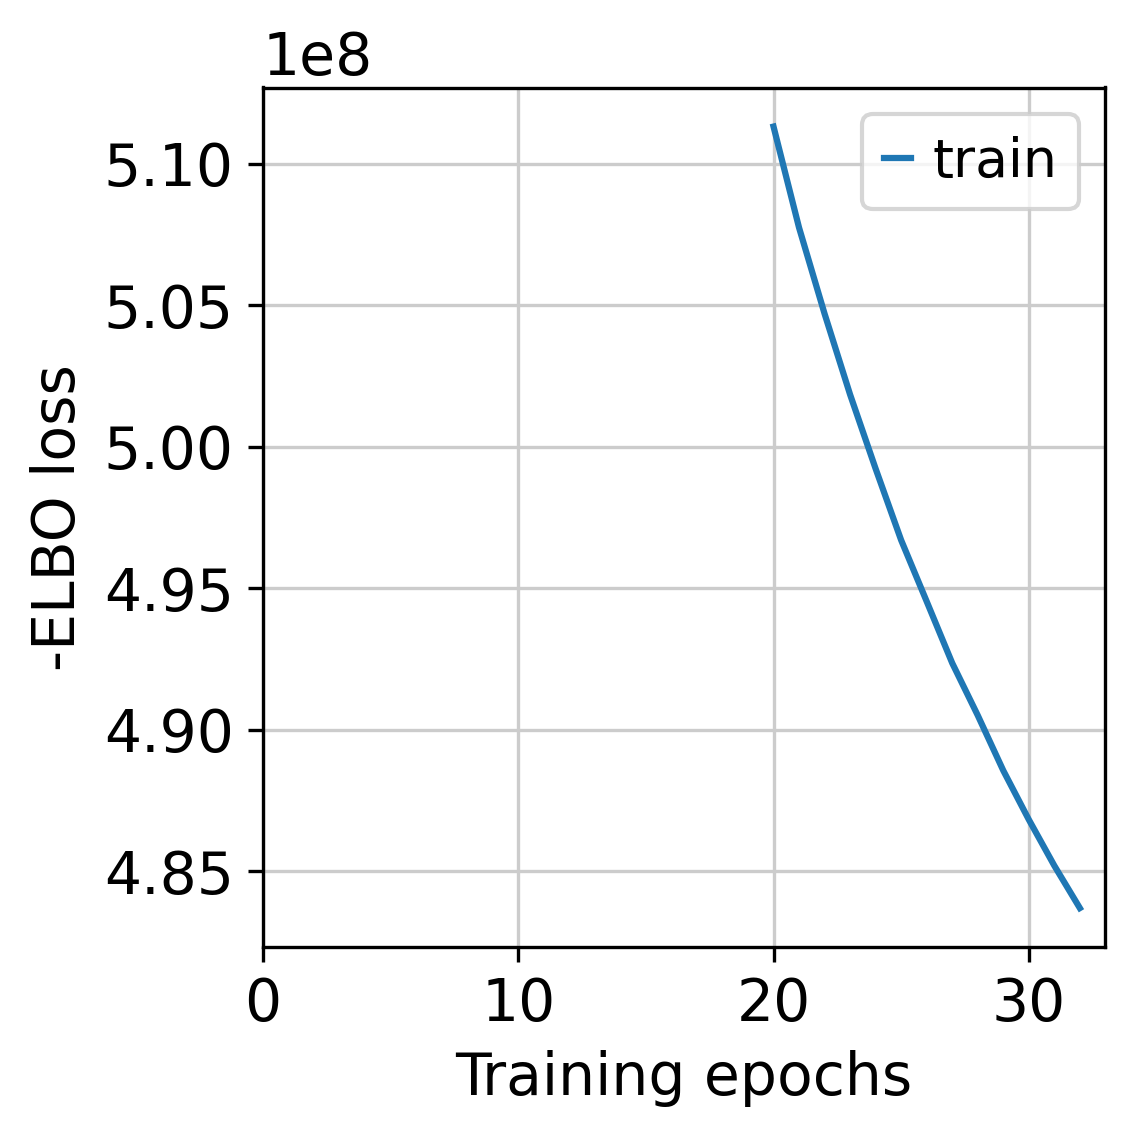

In [15]:
# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [27]:
ref_run_name

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_hyper2_paed_CITE_v11_v2/reference_signatures'

In [29]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
gex = mod.export_posterior(
    gex, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

Sampling global variables, sample: 100%|██████| 999/999 [00:34<00:00, 28.97it/s]


In [30]:
# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
gex.write(adata_file)
adata_file

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_hyper2_paed_CITE_v11_v2/reference_signatures/sc.h5ad'

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

In [32]:
mod.plot_QC

RegressionBackgroundDetectionTech model with the following params: 
n_factors: 625 
n_batch: 44 
Training status: Trained

<bound method RegressionModel.plot_QC of >

In [31]:
mod.plot_QC(use_n_obs = 5000)

ValueError: shapes (1000,19) and (20,14786) not aligned: 19 (dim 1) != 20 (dim 0)

In [4]:
## load single cell file 
gex = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
gex

AnnData object with n_obs × n_vars = 123873 × 14786
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_r

#read in results of regression model (if notebook is reloaded)
gex = sc.read("/nfs/team205/vk8/scripts/visium/cell2location_v2/results/reference_signatures/sc.h5ad")
adata_vis = sc.read("/nfs/team205/vk8/scripts/visium/cell2location_v2/results/adata_vis_2021-10-01.h5ad")

In [5]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in gex.varm.keys():
    inf_aver = gex.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in gex.uns['mod']['factor_names']]].copy()
else:
    inf_aver = gex.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in gex.uns['mod']['factor_names']]].copy()
inf_aver.columns = gex.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,0,1,2,3,4
LINC01409,0.050009,0.022630,0.089572,0.031026,0.013786
LINC01128,0.079870,0.059035,0.092223,0.063416,0.056279
LINC00115,0.006136,0.013395,0.037157,0.003356,0.004700
AL645608.2,0.904009,0.985821,0.955581,0.957253,0.960383
NOC2L,0.358246,0.151319,0.198945,0.145342,0.083540


## Cell2location: spatial mapping <a class="anchor" id="cell2location"></a>

In [6]:
#The model and output h5ad can be loaded later like this:
adata_vis_all = sc.read("/nfs/team205/ny1/ThymusSpatialAtlas/Figure2/data/Thymus_atlas_v2_Visium_raw_2023-08-02.h5ad")

In [7]:
adata_vis = adata_vis_all[adata_vis_all.obs['Age_group'] != 'fetal'].copy()

In [8]:
for i in adata_vis.uns['spatial'].keys():
    print(f'Deleting images from {i}')
    del adata_vis.uns['spatial'][i]['images']['hires']
    if 'hires5K' in adata_vis.uns['spatial'][i]['images'].keys():
        print("has hires")
        del adata_vis.uns['spatial'][i]['images']['hires5K']
    del adata_vis.uns['spatial'][i]['scalefactors']['tissue_hires5K_scalef']
    del adata_vis.uns['spatial'][i]['scalefactors']['tissue_hires_scalef']

Deleting images from spaceranger122_count_34880_WSSS_THYst9142086_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_34880_WSSS_THYst9142087_GRCh38-2020-A
Deleting images from spaceranger122_count_34880_WSSS_THYst9142088_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_34880_WSSS_THYst9142089_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_36136_WSSS_THYst9518030_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_36136_WSSS_THYst9518032_GRCh38-2020-A
has hires
Deleting images from spaceranger122_count_36136_WSSS_THYst9518033_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_36654_WSSS_F_IMMsp9838711_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_36811_WSSS_F_IMMsp9838716_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_42337_TA11486161_GRCh38-2020-A
has hires
Deleting images from spaceranger130_count_42337_TA11486162_GRCh38-2020-A
has hires
Deleting images from spacerang

adata_file = f"{ref_run_name}/sp.h5ad"
gex = sc.read('/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_all/reference_signatures/sc.h5ad')

#mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", gex)

In [9]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()

In [10]:
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
adata_vis

View of AnnData object with n_obs × n_vars = 38245 × 36588
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding',

In [11]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
#adata_vis = adata_vis[~adata_vis.obs['SampleID'].isin(['S000001583_U11FO2_D1_st9142089',\
#                                                     'V11J11-100_Z1-THY-FO2_A1_TA11486161',\
                                                 #   'V19D02-039_U09-THY-FO1a_C1_st9518032', \
#                                                    ]), intersect].copy()
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [12]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="SampleID",
                                                categorical_covariate_keys=['SlideID','section_thickness (um)'],continuous_covariate_keys=['Age(numeric)','n_genes_by_counts'])

Here you need to specify 2 user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`) - for detailed guidance on setting these hyperparameters and their impact see [the flow diagram and the note](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf).

<div class="alert alert-block alert-danger">
<b>Note!</b>
While you can often use the default value of `detection_alpha` hyperparameter, it is useful to  <b>adapt the expected cell abundance `N_cells_per_location` to every tissue</b>. This value can be estimated from paired histology images and as described in the note above. Change the value presented in this tutorial (`N_cells_per_location=30`) to the value observed in your your tissue.
</div>

In [13]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=50,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
) 

mod.view_anndata_setup()

In [14]:
mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/30000:   0%|                                      | 0/30000 [00:00<?, ?it/s]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /nfs/users/nfs_v/vk8/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Epoch 2/30000:   0%| | 1/30000 [00:03<28:00:18,  3.36s/it, v_num=1, elbo_train=4.4e+

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 7540/30000:  25%|▎| 7539/30000 [38:21<1:52:15,  3.33it/s, v_num=1, elbo_train=

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 13055/30000:  44%|▍| 13055/30000 [1:06:28<1:25:37,  3.30it/s, v_num=1, elbo_tr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 18598/30000:  62%|▌| 18598/30000 [1:34:46<59:06,  3.21it/s, v_num=1, elbo_trai

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 24167/30000:  81%|▊| 24166/30000 [2:03:14<29:51,  3.26it/s, v_num=1, elbo_trai

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 29648/30000:  99%|▉| 29647/30000 [2:31:16<01:47,  3.27it/s, v_num=1, elbo_trai

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
run_name

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_hyper2_paed_CITE_v11_v2/cell2location_map'

In [16]:
# Save model and visium data 
if not os.path.exists(run_name):
    os.mkdir(run_name)
adata_file = f"{run_name}/adata_vis.h5ad"
adata_vis.write(adata_file)
mod.save(f"{run_name}", overwrite=True)

# consider restarting kernel before this state 


In [3]:
# load model and visium data 
adata_vis = sc.read_h5ad(f"{run_name}/adata_vis.h5ad")
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File /nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_hyper2_paed
         _CITE_v11_v2/cell2location_map/model.pt already downloaded                          


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-65984e58-2b6b-21f8-41cd-7854ff83d259/0/0]
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/30000:   0%|                                            | 0/30000 [00:00<?, ?it/s]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /nfs/users/nfs_v/vk8/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Epoch 1/30000:   0%|     | 1/30000 [00:02<20:23:51,  2.45s/it, v_num=1, elbo_train=4.4e+8]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|     | 1/30000 [00:02<20:25:53,  2.45s/it, v_num=1, elbo_train=4.4e+8]


In [4]:
# load single cell file 
gex = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in gex.varm.keys():
    inf_aver = gex.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in gex.uns['mod']['factor_names']]].copy()
else:
    inf_aver = gex.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in gex.uns['mod']['factor_names']]].copy()
inf_aver.columns = gex.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,0,1,2,3,4
LINC01409,0.050009,0.022630,0.089572,0.031026,0.013786
LINC01128,0.079870,0.059035,0.092223,0.063416,0.056279
LINC00115,0.006136,0.013395,0.037157,0.003356,0.004700
AL645608.2,0.904009,0.985821,0.955581,0.957253,0.960383
NOC2L,0.358246,0.151319,0.198945,0.145342,0.083540


In [7]:
adata_vis = mod.export_posterior(
    adata_vis, add_to_obsm=["q50", "q05", "q95"], sample_kwargs={"batch_size": 1000}, use_quantiles = True
) 

In [12]:
adata_vis.obsm['q50_cell_abundance_w_sf'].shape

(38245, 625)

In [ ]:
# # In this section, we export the estimated cell abundance (summary of the posterior distribution).
# adata_vis = mod.export_posterior(
#     adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
# )

# adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
# expected_dict = mod.module.model.compute_expected_per_cell_type(
#     adata_vis.uns['mod']['post_sample_q05'], mod.adata_manager
# )

# # Add to anndata layers
# for i, n in enumerate(mod.factor_names_):
#     adata_vis.layers[n] = expected_dict['mu'][i]

In [6]:
# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_hyper2_paed_CITE_v11_v2/cell2location_map/sp.h5ad'